## Building Mapping Apps with Leafmap and Streamlit

We can leverage `leafmap` to create an interactive mapping dashboard that gives us the flexibility of using many different mapping backends and way to read a wide-variety of spatial data formats.

### Create a Mapping Dashboard

The code below creates an interactive mapping dashboard that displays the statistics of the selected region :

1. We start by creating the app directory `mapping_dashboard` and creating `app.py` with the following content. This code creates a layout with a sidebar using `st.sidebar()` and adds some widgets to it. Note that while we need to use `st.title()` for the main section, we use `st.sidebar.title()` for the sidebar.

`app.py`

In [ ]:
import streamlit as st

st.set_page_config(page_title='Dashboard', layout='wide')

st.title('Highway Dashboard')

st.sidebar.title('About')
st.sidebar.info('Explore the Highway Statistics')

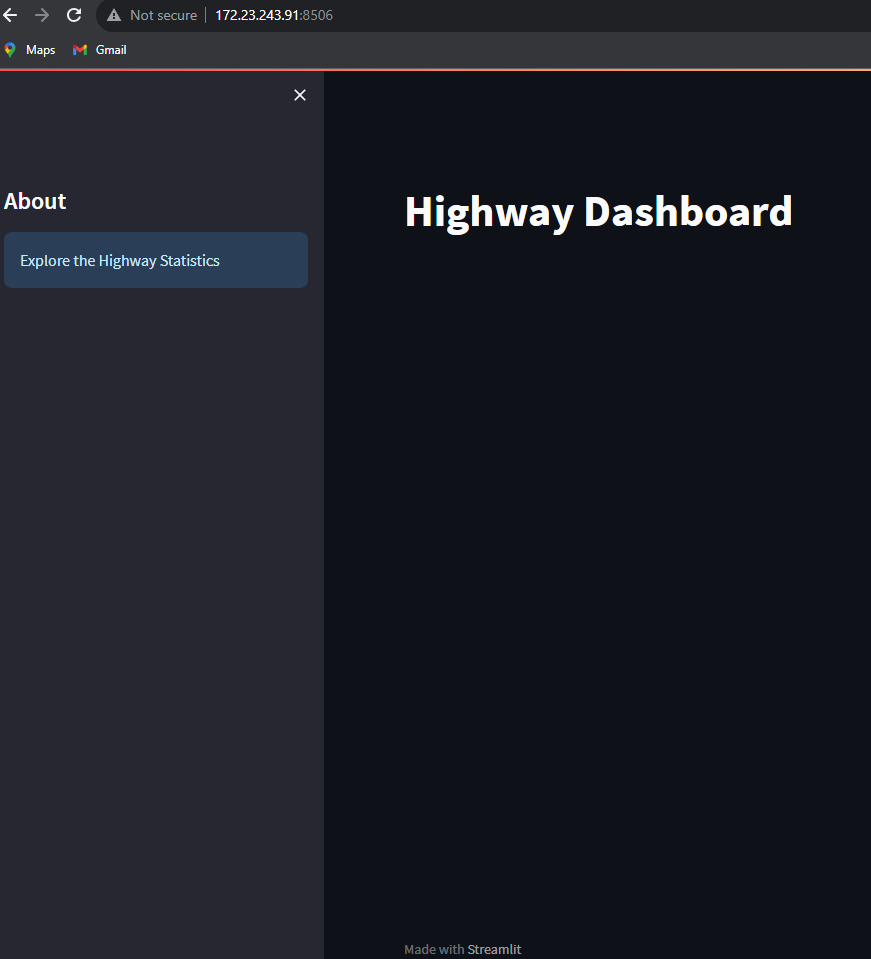

2. We now use geopandas to read 2 vector layers from a geopackage and pandas to read a CSV file containing road statistics. We put the code for data fetching inside a function and cache it using the `st.cache_data` decorator.

`app.py`

In [ ]:
import streamlit as st
import geopandas as gpd
import pandas as pd

# Cosmetic config
st.set_page_config(page_title='Dashboard', layout='wide')

st.title('Highway Dashboard')

st.sidebar.title('About')
st.sidebar.info('Explore the Highway Statistics')

# specify file path and filenames
data_url = 'https://storage.googleapis.com/spatialthoughts-public-data/python-dataviz/osm/'
gpkg_file = 'karnataka.gpkg'
csv_file = 'highway_lengths_by_district.csv'

@st.cache_data
# custom funciton to load in our spatial data
def read_gdf(url, layer):
    gdf = gpd.read_file(url, layer=layer)
    return gdf

@st.cache_data
# custom function to load road statistics
def read_csv(url):
    df = pd.read_csv(url)
    return df
    
# Process start
data_load_state = st.text('Loading data...')   

# Concatenate file names
gpkg_url = data_url + gpkg_file
csv_url = data_url + csv_file

# create districts GeoDataFrame
districts_gdf = read_gdf(gpkg_url, 'karnataka_districts')

# create roads GeoDataFrame
roads_gdf = read_gdf(gpkg_url, 'karnataka_highways')

# create non spatial road stats DataFrame
lengths_df = read_csv(csv_url)

# Process complete
data_load_state.text('Loading data... done!')

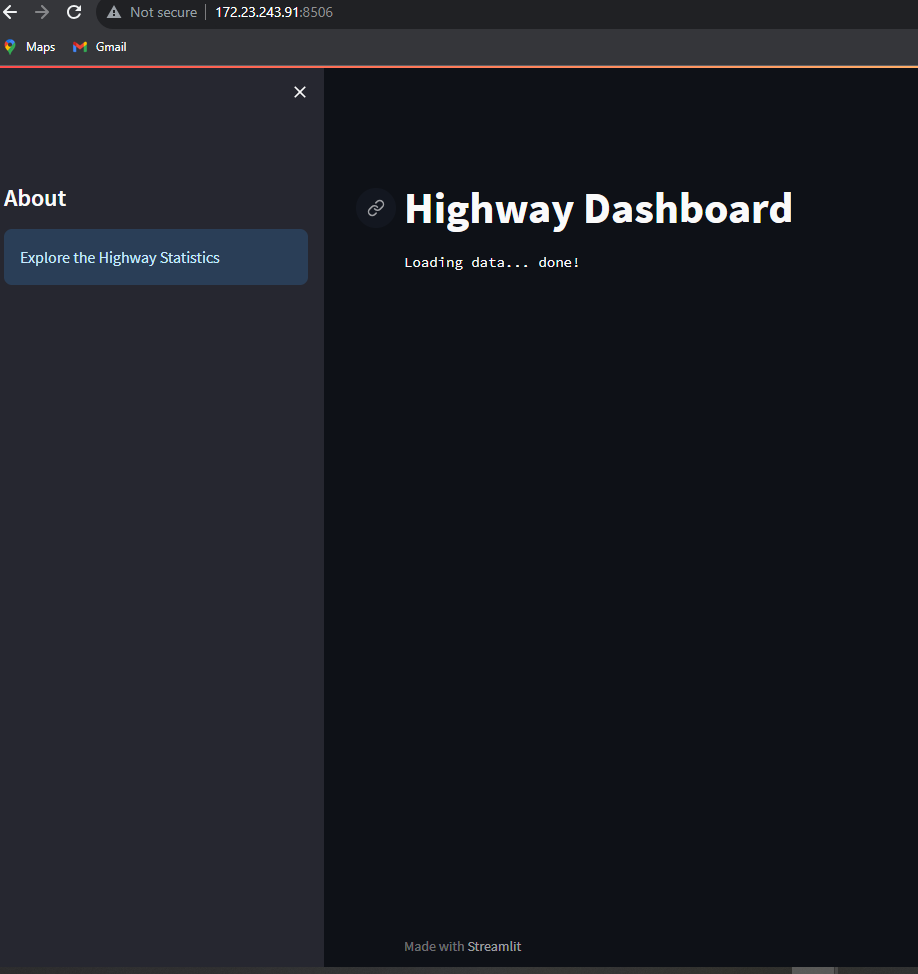

3. Now we use the information in the CSV file to display a chart in the sidebar.

`app/py`

In [ ]:
import streamlit as st
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Cosmetic config
st.set_page_config(page_title='Dashboard', layout='wide')

st.title('Highway Dashboard')

st.sidebar.title('About')
st.sidebar.info('Explore the Highway Statistics')

# specify file path and filenames
data_url = 'https://storage.googleapis.com/spatialthoughts-public-data/python-dataviz/osm/'
gpkg_file = 'karnataka.gpkg'
csv_file = 'highway_lengths_by_district.csv'

@st.cache_data
# custom funciton to load in our spatial data
def read_gdf(url, layer):
    gdf = gpd.read_file(url, layer=layer)
    return gdf

@st.cache_data
# custom funciton to load road statistics
def read_csv(url):
    df = pd.read_csv(url)
    return df

# Concatenate file names
gpkg_url = data_url + gpkg_file
csv_url = data_url + csv_file

# create districts GeoDataFrame
districts_gdf = read_gdf(gpkg_url, 'karnataka_districts')

# create roads GeoDataFrame
roads_gdf = read_gdf(gpkg_url, 'karnataka_highways')

# create non spatial road stats DataFrame
lengths_df = read_csv(csv_url)

# Add a dropdown for district selection and filter dataset based on user choice
districts = districts_gdf.DISTRICT.values
district = st.sidebar.selectbox('Select a District', districts)

district_lengths = lengths_df[lengths_df['DISTRICT'] == district]

# Visualize the user selection
fig, ax = plt.subplots(1, 1)
district_lengths.plot(kind='bar', ax=ax, color=['blue', 'red'],
    ylabel='Kilometers', xlabel='Category')
ax.set_xticklabels([])
stats = st.sidebar.pyplot(fig)

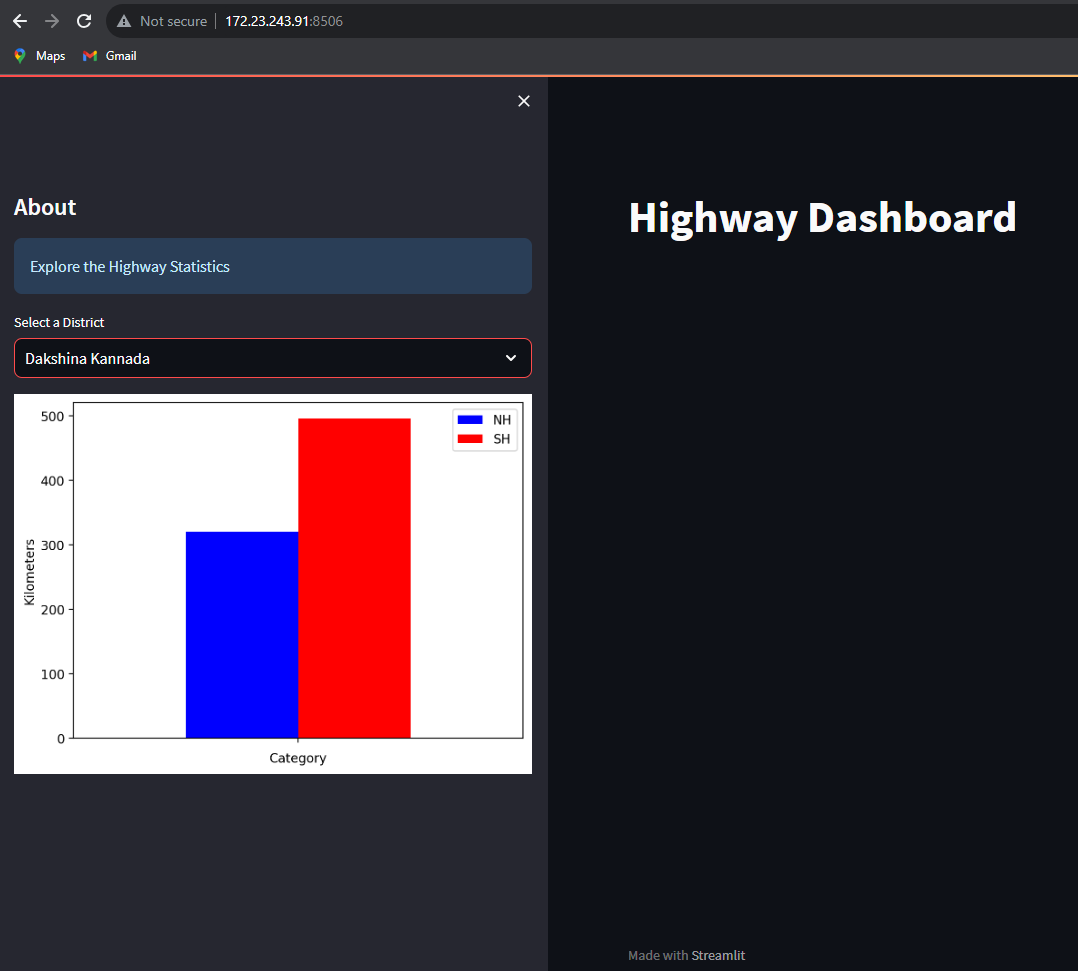

4. Now we create a folium map using `leafmap.Map()` and render the vector layers. We also add a third layer with the `boundary` of the selected district to highlight the selection.

`app.py`

In [ ]:
import streamlit as st
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import leafmap.foliumap as leafmap

# Cosmetic config
st.set_page_config(page_title='Dashboard', layout='wide')

st.title('Highway Dashboard')

st.sidebar.title('About')
st.sidebar.info('Explore the Highway Statistics')

# specify file path and filenames
data_url = 'https://storage.googleapis.com/spatialthoughts-public-data/python-dataviz/osm/'
gpkg_file = 'karnataka.gpkg'
csv_file = 'highway_lengths_by_district.csv'


@st.cache_data
# custom funciton to load in our spatial data
def read_gdf(url, layer):
    gdf = gpd.read_file(url, layer=layer)
    return gdf

@st.cache_data
# custom function to load road statistics
def read_csv(url):
    df = pd.read_csv(url)
    return df

# Concatenate file names
gpkg_url = data_url + gpkg_file
csv_url = data_url + csv_file

# create districts GeoDataFrame
districts_gdf = read_gdf(gpkg_url, 'karnataka_districts')

# create roads GeoDataFrame
roads_gdf = read_gdf(gpkg_url, 'karnataka_highways')

# create non spatial road stats DataFrame
lengths_df = read_csv(csv_url)

# Add a dropdown for district selection and filter dataset based on user choice
districts = districts_gdf.DISTRICT.values
district = st.sidebar.selectbox('Select a District', districts)

district_lengths = lengths_df[lengths_df['DISTRICT'] == district]

# Visualize the user selection
fig, ax = plt.subplots(1, 1)
district_lengths.plot(kind='bar', ax=ax, color=['blue', 'red'],
    ylabel='Kilometers', xlabel='Category')
ax.set_xticklabels([])
stats = st.sidebar.pyplot(fig)


# Create a Folium map
m = leafmap.Map(
    layers_control=True, # allows user to select layers of interest
    draw_control=False,
    measure_control=False,
    fullscreen_control=False,
)
m.add_basemap('CartoDB.DarkMatter')

# add the districts layer
m.add_gdf(
    gdf=districts_gdf,
    zoom_to_layer=False,
    layer_name='districts',
    info_mode='on_click',
    style={'color': '#7fcdbb', 'fillOpacity': 0.3, 'weight': 0.5},
    )

# filter for user district selection
selected_gdf = districts_gdf[districts_gdf['DISTRICT'] == district]


# add the user selected districts layer
m.add_gdf(
    gdf=selected_gdf,
    layer_name='selected',
    zoom_to_layer=True,
    info_mode=None,
    style={'color': 'yellow', 'fill': None, 'weight': 2}
 )


m_streamlit = m.to_streamlit(600, 600)

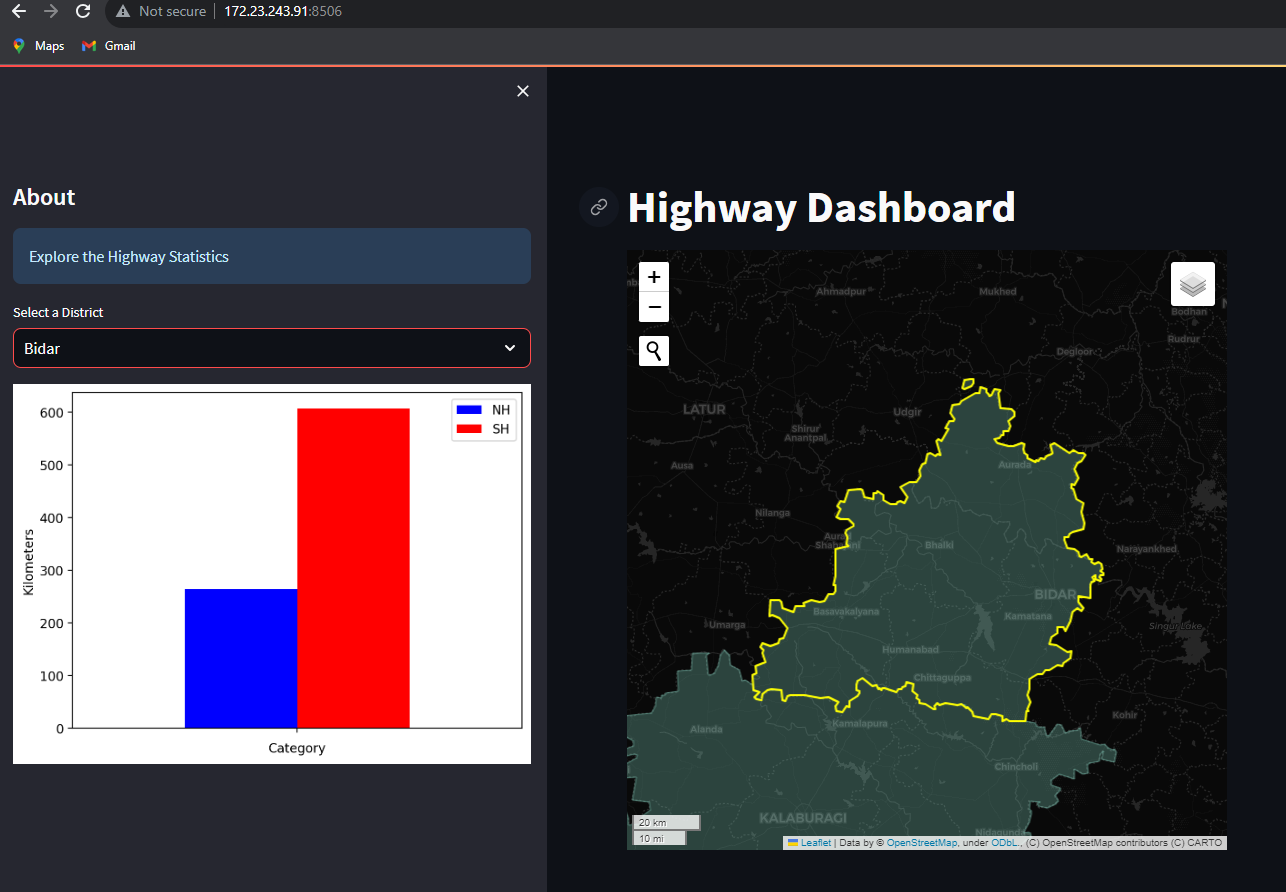

This is excellent. When a user selects a district they get 2 visuals - a bar chart of the road categories and the district highlighted on the map.

5. We can selectively load certain layers on the map using a user-input widget. Let’s add a checkbox that allows the user to overlay the roads on the map.


`app.py`

In [ ]:
import streamlit as st
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import leafmap.foliumap as leafmap

# Cosmetic config
st.set_page_config(page_title='Dashboard', layout='wide')

st.title('Highway Dashboard')

st.sidebar.title('About')
st.sidebar.info('Explore the Highway Statistics')

# Concatenate file names
data_url = 'https://storage.googleapis.com/spatialthoughts-public-data/python-dataviz/osm/'
gpkg_file = 'karnataka.gpkg'
csv_file = 'highway_lengths_by_district.csv'


@st.cache_data
# custom funciton to load in our spatial data
def read_gdf(url, layer):
    gdf = gpd.read_file(url, layer=layer)
    return gdf

@st.cache_data
# custom function to load road statistics
def read_csv(url):
    df = pd.read_csv(url)
    return df

# Concatenate file names
gpkg_url = data_url + gpkg_file
csv_url = data_url + csv_file


# create districts GeoDataFrame
districts_gdf = read_gdf(gpkg_url, 'karnataka_districts')

# create roads GeoDataFrame
roads_gdf = read_gdf(gpkg_url, 'karnataka_highways')

# create non spatial road stats DataFrame
lengths_df = read_csv(csv_url)

# Add a dropdown for district selection and filter dataset based on user choice
districts = districts_gdf.DISTRICT.values
district = st.sidebar.selectbox('Select a District', districts)

# Give the user option to addd a road overlay
overlay = st.sidebar.checkbox('Overlay roads')

# filter road lengths based on user district choice
district_lengths = lengths_df[lengths_df['DISTRICT'] == district]

# # Visualize the user selection using barchart
fig, ax = plt.subplots(1, 1)
district_lengths.plot(kind='bar', ax=ax, color=['blue', 'red'],
    ylabel='Kilometers', xlabel='Category')
ax.get_xaxis().set_ticklabels([])
stats = st.sidebar.pyplot(fig)

# Create a Folium map
m = leafmap.Map(
    layers_control=True,
    draw_control=False,
    measure_control=False,
    fullscreen_control=False,
)

# Add basemap
m.add_basemap('CartoDB.DarkMatter')

# Add districts layer
m.add_gdf(
    gdf=districts_gdf,
    zoom_to_layer=False,
    layer_name='districts',
    info_mode='on_click',
    style={'color': '#7fcdbb', 'fillOpacity': 0.3, 'weight': 0.5},
    )

# add roads layer if selected by user
if overlay:
    m.add_gdf(
        gdf=roads_gdf,
        zoom_to_layer=False,
        layer_name='highways',
        info_mode=None,
        style={'color': '#225ea8', 'weight': 1.5},
    )

# filter for user district selection
selected_gdf = districts_gdf[districts_gdf['DISTRICT'] == district]

# add the user selected districts layer
m.add_gdf(
    gdf=selected_gdf,
    layer_name='selected',
    zoom_to_layer=True,
    info_mode=None,
    style={'color': 'yellow', 'fill': None, 'weight': 2}
 )

m_streamlit = m.to_streamlit(600, 600)